In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Cassiopeia, install this version: https://github.com/pjb7687/Cassiopeia
# The orignal version is available at https://cassiopeia-lineage.readthedocs.io/en/latest/
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.lineage_solver import lineage_solver as ls

# ForceAtlas2, available at https://pypi.org/project/ForceAtlas2
from fa2 import ForceAtlas2

/home/pjb7687/.local/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
# Assuming that the "gisaid_cov2020_sequences.fasta" file exists at the working directory.
# According to the EULA, this file should be downloaded directly from GISAID website.

# FAMSA, available at https://github.com/refresh-bio/FAMSA
# GPU acceleration doesn't seem to work, but it is still quite fast
!famsa-gpu-1.3.2-linux gisaid_cov2020_sequences.fasta aligned.fasta

FAMSA (Fast and Accurate Multiple Sequence Alignment) ver. 1.3.2 CPU and GPU
  by S. Deorowicz, A. Debudaj-Grabysz, A. Gudys (2020-02-21)

Done!


In [3]:
with open("aligned.fasta") as f, open("aligned_nospaces.fasta", "w") as fo:
    for line in f:
        if line[0] == '>':
            line = line.replace(" ", "_")
        fo.write(line)

In [4]:
# SNP-sites, available at https://github.com/sanger-pathogens/snp-sites
!snp-sites -v -c -o variants.vcf aligned_nospaces.fasta

In [5]:
var_vecs = []
var_ids = []
with open("variants.vcf") as f:
    for line in f:
        if line[0] == "#":
            if line[1] != "#":
                headers = np.array(line.strip().replace("|", "@").split('\t')[9:]) # bar sign can confuse Cassiopeia
            continue
        entries = line.strip().split('\t')
        if "," in entries[4]:
            print("Found multiple SNVs at the same site!")
            continue # ignore multiple SNVs (so far this has never happened yet)
        var_ids.append("_".join([entries[1], entries[3], entries[4]]))
        var_vecs.append([int(i) for i in entries[9:]])
var_mat = np.array(var_vecs).T

In [6]:
# Dedupicate the same strains
vecs_stringified = np.array(['|'.join(map(str, v)) for v in var_mat])
uniq_vecs, uniq_indices = np.unique(vecs_stringified, return_index = True)
uniq_headers = ['\n'.join(headers[vs == vecs_stringified]) for vs in np.unique(vecs_stringified)]

var_mat_uniq = var_mat[uniq_indices, :]

In [7]:
nodes = [Node(str(node_id), node_vec) for node_id, node_vec in enumerate(var_mat_uniq)]
tree = ls.solve_lineage_instance(nodes, method="ilp")[0]
net = tree.get_network().to_undirected()

Started new thread for: 0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0 (num targets = 108) , pid = dbe381b38fc59eda071e715ef335468d
Estimating potential graph with maximum neighborhood size of 10000 with lca distance of 18 (pid: dbe381b38fc59eda071e715ef335468d)
LCA Distance 0 completed with a neighborhood size of 12 (pid: dbe381b38fc59eda071e715ef335468d)
LCA Distance 1 completed with a neighborhood size of 12 (pid: dbe381b38fc59eda071e715ef335468d)
LCA Distance 2 completed with a neighborhood size of 12 (pid: dbe381b38fc59eda071e715ef335468d)
LCA Distance 5 completed with a neighborhood size of 12 (pid: dbe381b38fc59eda07

In [8]:
unknown_idx = 1
for n in net:
    try:
        n.name = str(list(vecs_stringified[uniq_indices]).index(n.name.split('_')[0]))
    except:
        n.name = "Unknown" + str(unknown_idx)
        unknown_idx += 1

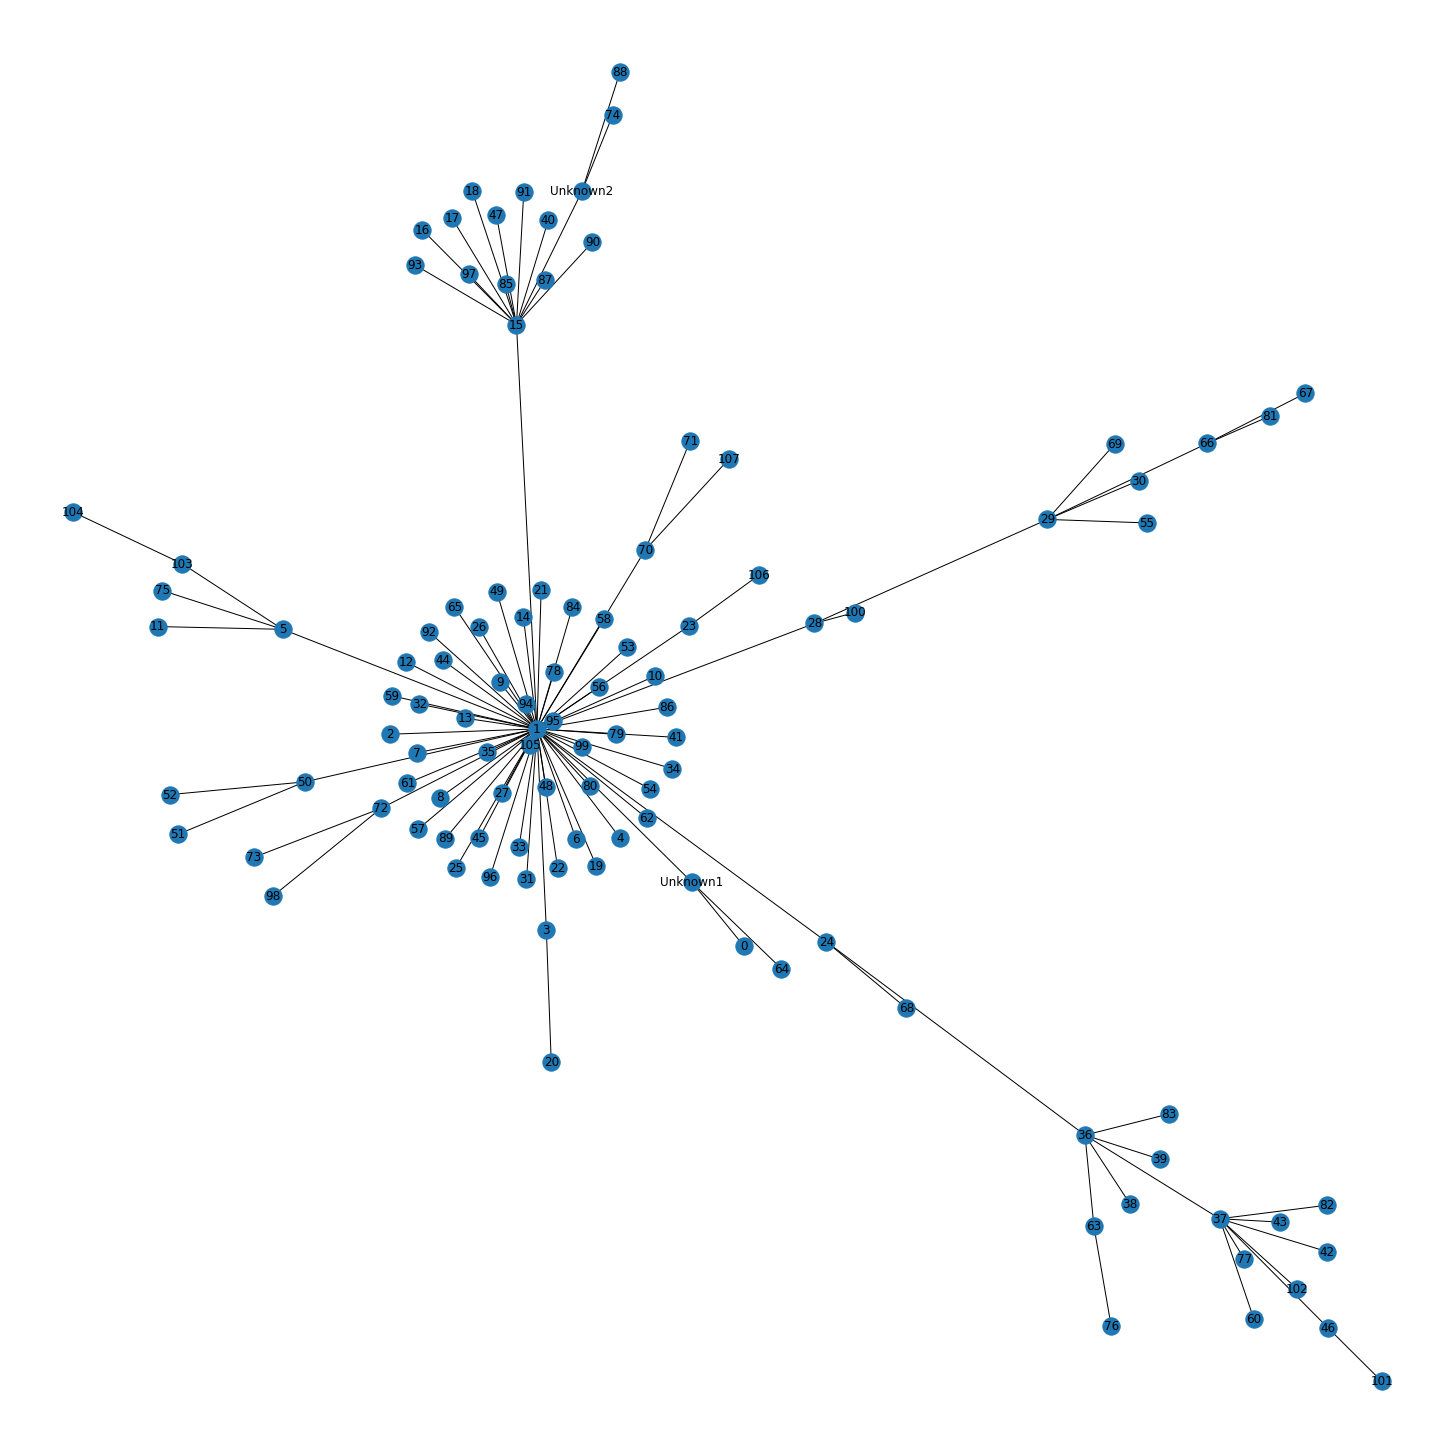

In [9]:
plt.figure(figsize=[20, 20])
nx.draw(net, with_labels=True)
pass

In [10]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.5,
                        strongGravityMode=False,
                        gravity=2,

                        # Log
                        verbose=True)

In [11]:
pos_fa2 = forceatlas2.forceatlas2_networkx_layout(net, pos=nx.spring_layout(net), iterations=10000)

100%|██████████| 10000/10000 [00:02<00:00, 4434.26it/s]

BarnesHut Approximation  took  0.49  seconds
Repulsion forces  took  1.32  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


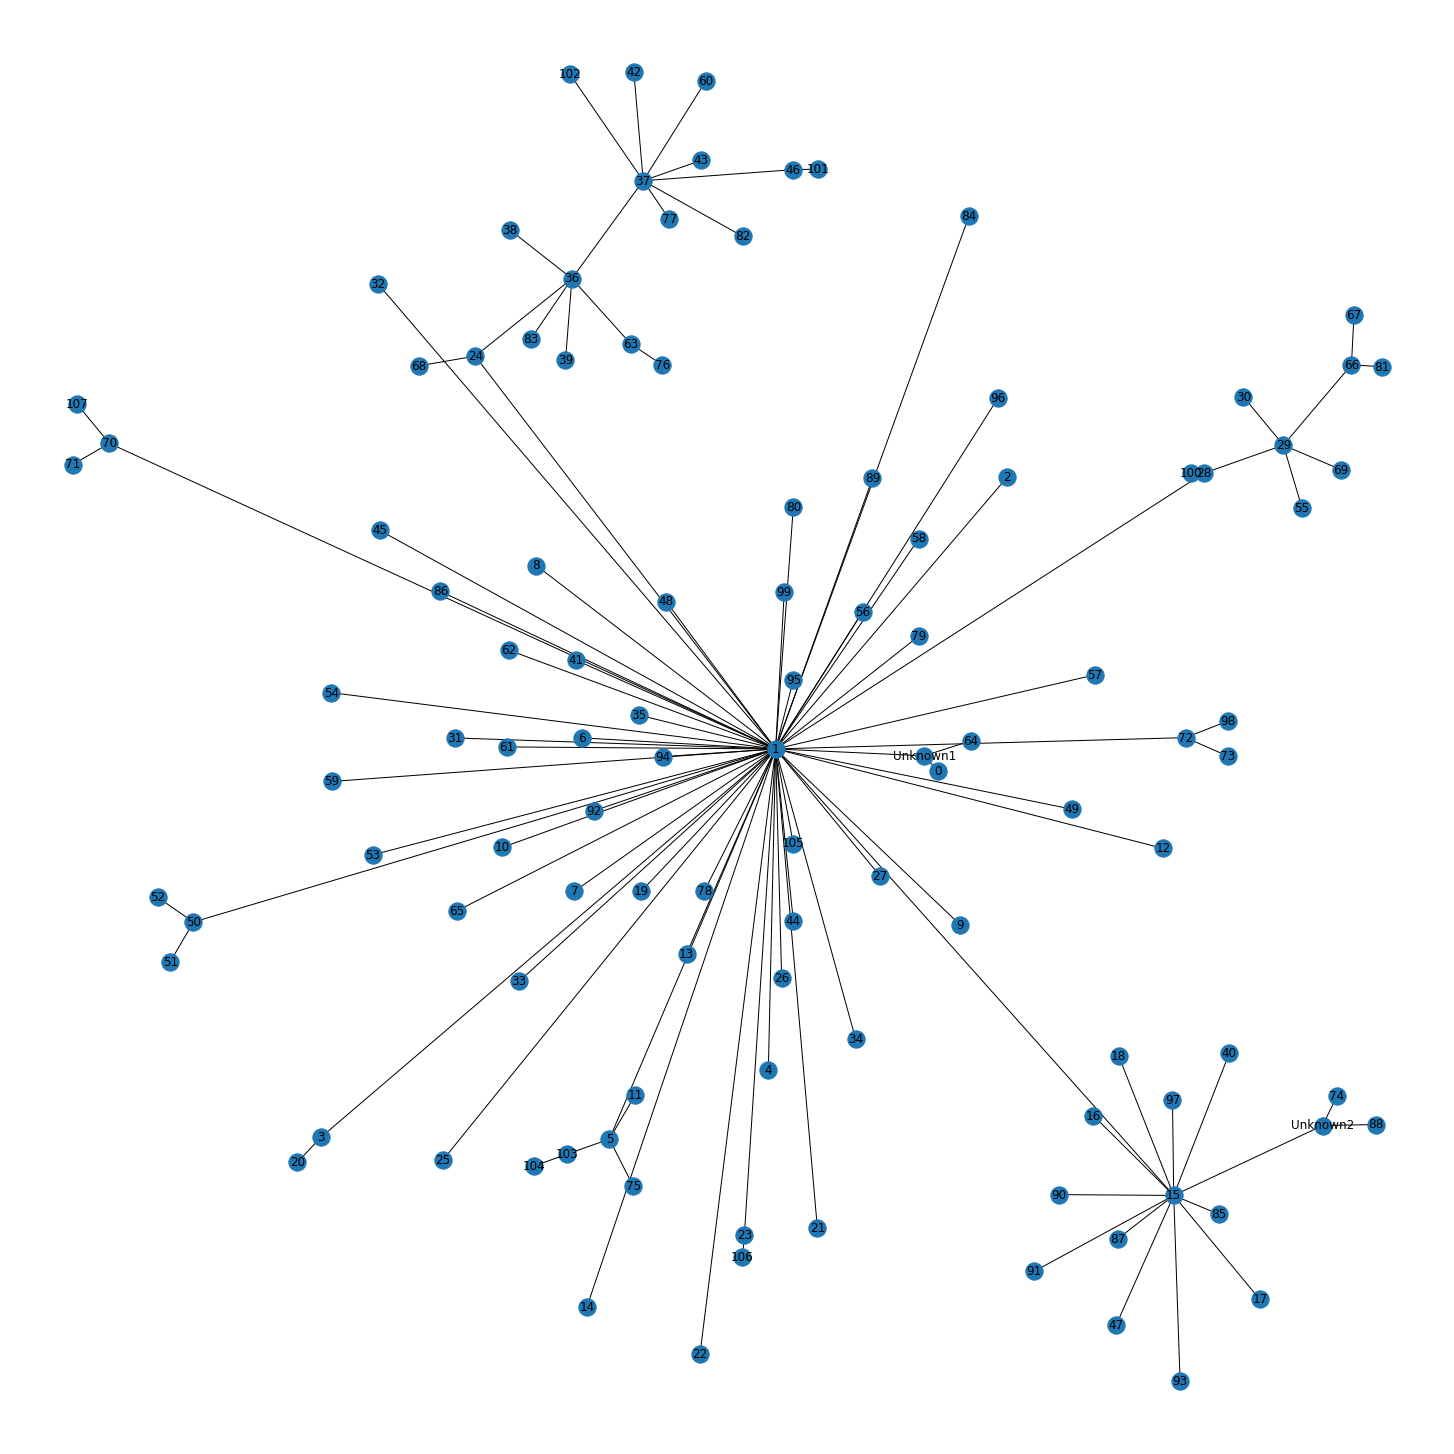

In [12]:
plt.figure(figsize=[20, 20])
nx.draw(net, pos=pos_fa2, with_labels=True)
pass

In [13]:
# Export to Json for visualization with vis.js
import json
from datetime import datetime

nodes = []
node_details = {}
for k in net.nodes:
    if not "Unknown" in k.name:
        node_details[k.name] = [e.split("@") for e in uniq_headers[int(k.name)].split("\n")]
    nodes.append({"id": k.name})
edges = [{"from": i.name, "to": j.name} for i, j in net.edges]

current_datetime = datetime.now().strftime("%d %b %Y, %H:%M (CET)")
s = "var updated_datetime = \"%s\";\n\nvar nodes = new vis.DataSet(%s);\n\nvar edges = new vis.DataSet(%s);\n\nvar node_details = %s;\n"%(current_datetime, json.dumps(nodes), json.dumps(edges), json.dumps(node_details))
with open("network_data.js", "w") as f:
    f.write(s)

In [ ]:
!git add covid19.ipynb network_data.js
!git commit -m "Data update "